In [48]:
using Flux
using Flux: @epochs, throttle
using ExprOptimization
using Base.Iterators: repeated
using BSON
using Plots
using LinearAlgebra
using JLD2, FileIO


# Functions to plot loss

In [49]:
function plotLoss(lossVals)
    floatLossVals = [Tracker.data(lv) for lv in lossVals]
    gr(fmt=:png)
    plot()
    plot!(floatLossVals,
        xlabel = "time",
        ylabel = "loss",
        label = "mse loss",
        title = "loss evolution")
end

plotLoss (generic function with 1 method)

In [94]:
function plotLossOnSameFigure!(lossVals, lbl = "mse loss", colorNum = nothing)
    floatLossVals = [Tracker.data(lv) for lv in lossVals]
    if colorNum != nothing
        p = plot!(floatLossVals,
        xlabel = "epochs",
        ylabel = "loss",
        label = lbl,
        title = "Loss evolution for different models",
        color = colorNum)
    else
        p = plot!(floatLossVals,
            xlabel = "epochs",
            ylabel = "loss",
            label = lbl,
            title = "Loss evolution for different models")
    end
    return p
end

plotLossOnSameFigure! (generic function with 3 methods)

# Try with the trajectory training data and model

In [97]:
function train_model(model, X_train, Y_train; verbose = false)
    loss(x, y) = begin 
        Flux.reset!(model)
        Flux.mse(model(x), y)        
    end
    data = repeated((X_train, Y_train), 1)
    opt = Flux.Optimise.ADAM()
    lossVals = [loss(X_train,Y_train)]
    evalcb = () -> begin curLoss = loss(X_train,Y_train)
        push!(lossVals, curLoss)
        verbose && @show(curLoss) end
#     evalcb2 = () -> BSON.@save "model-flux-trial.bson" model
    verbose && @show loss(X_train,Y_train)
    @epochs 10 Flux.train!(loss, params(model), data, opt, cb = [throttle(evalcb, 30)])
#     @epochs 10 Flux.train!(loss, params(model), data, opt, cb = [throttle(evalcb, 30), throttle(evalcb2, 60)])
    verbose && @show lossVals
    verbose && plotLoss(lossVals)
    return lossVals
end

train_model (generic function with 1 method)

In [98]:
function loss(tree::RuleNode, grammar::Grammar)
    ex = get_executable(tree, grammar)
    model = []
    model = Core.eval(S,ex)
    push!(models_tested, model)
    loss_vals = train_model(model, X_train[1,:], Y_train[1,:], verbose = false)

    Y_NN = model(X_test[1,:])
    Y_NN = [Tracker.data(ynn) for ynn in Y_NN]
    los = norm(Y_NN - Y_test[1,:])
    push!(model_final_losses, los)
    push!(model_all_losses, loss_vals)
    println("returning $los")
    Flux.reset!(model)
    Flux.truncate!(model)
    return los
end

loss (generic function with 1 method)

In [99]:
function findAverageFinalLoss(data)
    avg = 0.0
    for i = 1:length(data)
        last_loss = data[i][end]
        avg = avg + last_loss

    end
    avg = avg/length(data)
    return avg
end

findAverageFinalLoss (generic function with 1 method)

In [104]:
input_size = 182
output_size = 180
JLD2.@load "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2" train_input_collected_first_only train_output_collected_first_only
@show size(train_input_collected_first_only)
@show size(train_output_collected_first_only)

X_train = train_input_collected_first_only[1:500,:]
X_test = train_input_collected_first_only[501:end,:]

Y_train = train_output_collected_first_only[1:500, :]
Y_test = train_output_collected_first_only[501:end, :]

@show size(X_train)
@show size(X_test)
@show size(Y_train)
@show size(Y_test)

size(train_input_collected_first_only) = (646, 182)
size(train_output_collected_first_only) = (646, 180)
size(X_train) = (500, 182)
size(X_test) = (146, 182)
size(Y_train) = (500, 180)
size(Y_test) = (146, 180)


(146, 180)

In [122]:
const grammar = @grammar begin
model =  Chain(in_layer1, layer1, layer1, out_layer1) | Chain(in_layer2, layer2, layer2, out_layer2) | Chain(in_layer3, layer3, layer3, out_layer3) | Chain(in_layer3, layer3, layer3, out_layer3) | Chain(in_layer3, out_layer3)
in_layer1 = Dense(input_size, 256, activation)
out_layer1 = Dense(256, output_size, activation)
layer1 = Dense(256,256, activation)
in_layer2 = Dense(input_size, 512, activation)
out_layer2 = Dense(512, output_size, activation)
layer2 = Dense(512,512, activation)
in_layer3 = Dense(input_size, 64, activation)
out_layer3 = Dense(64, output_size, activation)
layer3 = Dense(64,64, activation)
RNNlayer = RNN(256,256, activation)
activation = relu | tanh
end

const S = SymbolTable(grammar)

Dict{Symbol,Any} with 7 entries:
  :output_size => 180
  :RNN         => RNN
  :relu        => relu
  :Chain       => Chain
  :Dense       => Dense
  :input_size  => 182
  :tanh        => tanh

In [123]:
using Random
Random.seed!(9)
p = MonteCarlo(20, 4)

models_tested = []
model_final_losses = []
model_all_losses = []

results_mc = optimize(p, grammar, :model, loss, verbose = true)


samples: 1 of 20
returning 0.8842768498238303
samples: 2 of 20
returning 1.7560886327395318
samples: 3 of 20


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/

returning 1.4349376410007852
samples: 4 of 20


┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/

returning 1.2366885254586075
samples: 5 of 20


┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/

returning 0.9388641615134686
samples: 6 of 20


┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise

returning 0.9299486640106145
samples: 7 of 20


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


returning 1.365037650211633
samples: 8 of 20


┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise

returning 1.1543090988328184
samples: 9 of 20


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


returning 0.9367980757138976


┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


samples: 10 of 20


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


returning 1.6495454543958477


┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


samples: 11 of 20


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


returning 1.359921582001161
samples: 12 of 20


┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/

returning 1.6048500528014187
samples: 13 of 20


┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


returning 1.1068713133314971
samples: 14 of 20


┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


returning 0.9363965529858992


┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


samples: 15 of 20
returning 1.6715425435864881
samples: 16 of 20


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/

returning 3.808657299730742
samples: 17 of 20


┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/

returning 1.0126340349799374
samples: 18 of 20
returning 2.6069583255835966
samples: 19 of 20


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/

returning 2.0808111558915634
samples: 20 of 20


┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/

returning 1.6574460520244916


┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


ExprOptResult(4{12{17}14{16}14{16}13{16}}, 0.8842768498238303, :(Chain(Dense(input_size, 64, tanh), Dense(64, 64, relu), Dense(64, 64, relu), Dense(64, output_size, relu))), nothing)

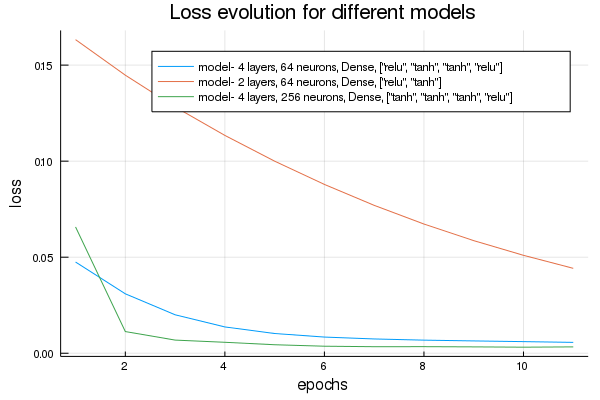

In [126]:
gr(fmt=:png)
plot()
for i = 15:17
#     if i==9
#         continue
#     end
    this_model_losses = model_all_losses[i]
    this_model = models_tested[i]
    num_layers = length(this_model.layers)
    num_neurons = size(this_model.layers[1].W, 1)
    typelayer = num_layers ==3 ? "RNN" : "Dense"
    act_list=[]
    if typelayer == "RNN"
        push!(act_list, "tanh")
    else
        for j = 1:num_layers
            act = this_model.layers[j].σ
            if act == NNlib.relu
                push!(act_list,"relu")
            else
                push!(act_list,"tanh")
            end
        end
    end
    str_act_list = string.(act_list)
    p = plotLossOnSameFigure!(this_model_losses, "model- $num_layers layers, $num_neurons neurons, $typelayer, $str_act_list")
#     colorNum = findColorNum(num_layers, num_neurons)
#     p = plotLossOnSameFigure!(this_model_losses, "model- $num_layers layers with $num_neurons neurons", colorNum)
end
display(p)

# Pretty printing purposes

In [ ]:
@grammar begin
model =  Chain(in_layer1, layer1, layer1, out_layer1) 
    | Chain(in_layer2, layer2, layer2, out_layer2) 
    | Chain(in_layer3, layer3, layer3, out_layer3) 
    | Chain(in_layer1, RNNlayer, out_layer1) 
    | Chain(in_layer1, out_layer1) 
    | Chain(in_layer2, out_layer2) 
    | Chain(in_layer3, out_layer3) 
in_layer1  = Dense(input_size, 256, activation)
out_layer1 = Dense(256, output_size, activation)
layer1     = Dense(256,256, activation)
in_layer2  = Dense(input_size, 512, activation)
out_layer2 = Dense(512, output_size, activation)
layer2     = Dense(512,512, activation)
in_layer3  = Dense(input_size, 64, activation)
out_layer3 = Dense(64, output_size, activation)
layer3     = Dense(64,64, activation)
RNNlayer   = RNN(256,256, activation)
activation = relu | tanh
end

In [ ]:
const grammar = 



const S = SymbolTable(grammar)

# Try with the real training data and model

In [51]:
function train_model(model, X_train, Y_train; verbose = false)
    loss(x, y) = begin 
        Flux.reset!(model)
        Flux.mse(model(x), y)        
    end
    data = repeated((X_train, Y_train), 1)
    opt = Flux.Optimise.ADAM()
    lossVals = [loss(X_train,Y_train)]
    evalcb = () -> begin curLoss = loss(X_train,Y_train)
        push!(lossVals, curLoss)
        verbose && @show(curLoss) end
#     evalcb2 = () -> BSON.@save "model-flux-trial.bson" model
    verbose && @show loss(X_train,Y_train)
    @epochs 10 Flux.train!(loss, params(model), data, opt, cb = [throttle(evalcb, 30)])
#     @epochs 10 Flux.train!(loss, params(model), data, opt, cb = [throttle(evalcb, 30), throttle(evalcb2, 60)])
    verbose && @show lossVals
    verbose && plotLoss(lossVals)
    return lossVals
end

train_model (generic function with 1 method)

In [52]:
function loss(tree::RuleNode, grammar::Grammar)
    ex = get_executable(tree, grammar)
    model = []
    model = Core.eval(S,ex)
    push!(models_tested, model)
    loss_vals = train_model(model, X_train[1,:], Y_train[1,:], verbose = false)

    Y_NN = model(X_test[1,:])
    Y_NN = [Tracker.data(ynn) for ynn in Y_NN]
    los = norm(Y_NN - Y_test[1,:])
    push!(model_final_losses, los)
    push!(model_all_losses, loss_vals)
    println("returning $los")
    Flux.reset!(model)
    Flux.truncate!(model)
    return los
end

loss (generic function with 1 method)

In [53]:
function findColorNum(num_layers, num_neurons)
    if num_layers ==4 
        if num_neurons == 256
            return 1
        else
            return 2
        end
    elseif num_layers ==5
        if num_neurons == 256
            return 3
        else
            return 4
        end
    end
end

findColorNum (generic function with 1 method)

In [54]:
function findAverageFinalLoss(data)
    avg = 0.0
    for i = 1:length(data)
        last_loss = data[i][end]
        avg = avg + last_loss

    end
    avg = avg/length(data)
    return avg
end

findAverageFinalLoss (generic function with 1 method)

In [55]:
input_size = 188
output_size = 6
JLD2.@load "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelWithDuals2.jld2" train_input_collected train_output_collected
@show size(train_input_collected)
@show size(train_output_collected)

X_train = train_input_collected[1:1200,:]
X_test = train_input_collected[1200:end,:]

Y_train = train_output_collected[1:1200, 181:186]
Y_test = train_output_collected[1200:end, 181:186]

@show size(X_train)
@show size(X_test)
@show size(Y_train)
@show size(Y_test)

size(train_input_collected) = (1560, 188)
size(train_output_collected) = (1560, 186)
size(X_train) = (1200, 188)
size(X_test) = (361, 188)
size(Y_train) = (1200, 6)
size(Y_test) = (361, 6)


(361, 6)

In [59]:
const grammar = @grammar begin
# model = Chain(in_layer1, layer1, layer1, out_layer1) 

model = Chain(in_layer1, RNNlayer, out_layer1) | Chain(in_layer1, layer1, layer1, out_layer1) | Chain(in_layer1, layer1, layer1, layer1, out_layer1) | Chain(in_layer2, layer2, layer2, out_layer2) | Chain(in_layer2, layer2, layer2, layer2, out_layer2)

# model = Chain(in_layer1, layer1, layer1, out_layer1) | Chain(in_layer1, layer1, layer1, layer1, out_layer1) | Chain(in_layer2, layer2, layer2, out_layer2) | Chain(in_layer2, layer2, layer2, layer2, out_layer2)
in_layer1 = Dense(input_size, 256, activation)
out_layer1 = Dense(256, output_size, activation)
layer1 = Dense(256,256, activation)
in_layer2 = Dense(input_size, 512, activation)
out_layer2 = Dense(512, output_size, activation)
layer2 = Dense(512,512, activation)
RNNlayer = RNN(256,256, activation)
activation = relu | tanh
end

const S = SymbolTable(grammar)

Dict{Symbol,Any} with 7 entries:
  :output_size => 6
  :RNN         => RNN
  :relu        => relu
  :Chain       => Chain
  :Dense       => Dense
  :input_size  => 188
  :tanh        => tanh

In [60]:
using Random
Random.seed!(9)
p = MonteCarlo(10, 4)

models_tested = []
model_final_losses = []
model_all_losses = []

results_mc = optimize(p, grammar, :model, loss, verbose = true)


samples: 1 of 10


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


returning 2.0008287601336696
samples: 2 of 10


┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise

returning 2.272608916832416
samples: 3 of 10


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


returning 1.529149062001534
samples: 4 of 10


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


returning 1.9443414010282862


┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


samples: 5 of 10


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


returning 1.5037518044183946
samples: 6 of 10


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


returning 1.2941992190383524
samples: 7 of 10


┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise

returning 2.467461389430692
samples: 8 of 10


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


returning 1.1845286897917582
samples: 9 of 10


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


returning 1.4737856083650458
samples: 10 of 10


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


returning 1.5237877597404483


ExprOptResult(4{9{14}11{14}11{14}10{13}}, 1.1845286897917582, :(Chain(Dense(input_size, 512, tanh), Dense(512, 512, tanh), Dense(512, 512, tanh), Dense(512, output_size, relu))), nothing)

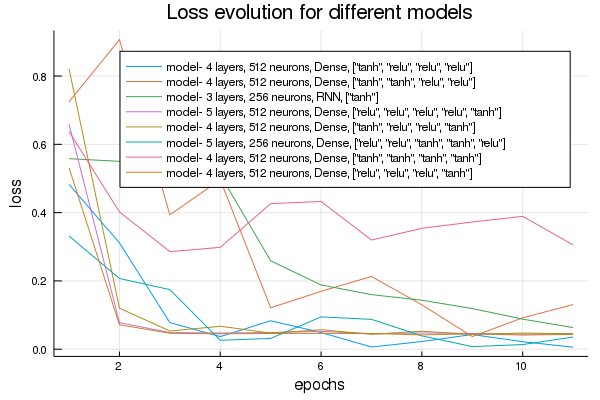

In [95]:
gr(fmt=:png)
plot()
for i = 1:10
    if i==2 || i==8
        continue
    end
    this_model_losses = model_all_losses[i]
    this_model = models_tested[i]
    num_layers = length(this_model.layers)
    num_neurons = size(this_model.layers[1].W, 1)
    typelayer = num_layers ==3 ? "RNN" : "Dense"
    act_list=[]
    if typelayer == "RNN"
        push!(act_list, "tanh")
    else
        for j = 1:num_layers
            act = this_model.layers[j].σ
            if act == NNlib.relu
                push!(act_list,"relu")
            else
                push!(act_list,"tanh")
            end
        end
    end
    str_act_list = string.(act_list)
    p = plotLossOnSameFigure!(this_model_losses, "model- $num_layers layers, $num_neurons neurons, $typelayer, $str_act_list")
#     colorNum = findColorNum(num_layers, num_neurons)
#     p = plotLossOnSameFigure!(this_model_losses, "model- $num_layers layers with $num_neurons neurons", colorNum)
end
display(p)

In [96]:
(results_mc.expr, results_mc.loss)


(:(Chain(Dense(input_size, 512, tanh), Dense(512, 512, tanh), Dense(512, 512, tanh), Dense(512, output_size, relu))), 1.1845286897917582)

In [69]:
gr(fmt=:png)
plot()
p = plotModelLosses!(models_tested, model_all_losses)
display(p)


nothing

In [58]:
findAverageFinalLoss(model_all_losses)

0.20251968156582753 (tracked)

In [44]:
RNN_layer_256_models_tested = models_tested
RNN_layer_256_model_final_losses = model_final_losses
RNN_layer_256_model_all_losses = model_all_losses
# average_final_loss = mean()
(results_mc.expr, results_mc.loss)
# @show length(four_layer_256_model_all_losses)
# @show models_tested
# @show model_final_losses
# @show model_all_losses

(:(Chain(Dense(input_size, 256, relu), RNN(256, 256, relu), Dense(256, output_size, relu))), 1.2200877368952747)

In [45]:
data = RNN_layer_256_model_all_losses
avg_RNN_layer_256_model = findAverageFinalLoss(data)

0.15696713198803022 (tracked)

In [90]:
@show length(model_all_losses[1])

length(model_all_losses[1]) = 11


11

In [91]:
for i = 1:length(model_all_losses)
    this_model_losses = model_all_losses[i]
    this_model = models_tested[i]
    num_layers = length(this_model.layers)
    num_neurons = size(this_model.layers[1].W, 1)
    @show this_model
    @show num_layers
    @show num_neurons
#     p = plotLossOnSameFigure!(this_model_losses, "model_$i")
end

this_model = Chain(Dense(188, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 6, NNlib.relu))
num_layers = 5
num_neurons = 512
this_model = Chain(Dense(188, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 512, NNlib.relu), Dense(512, 6, NNlib.relu))
num_layers = 5
num_neurons = 512
this_model = Chain(Dense(188, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 6, NNlib.relu))
num_layers = 4
num_neurons = 256
this_model = Chain(Dense(188, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 6, NNlib.relu))
num_layers = 5
num_neurons = 256
this_model = Chain(Dense(188, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 6, NNlib.relu))
num_layers = 5
num_neurons = 256


In [66]:
function plotModelLosses!(models_tested, model_all_losses)
    for i = 1:length(model_all_losses)
        this_model_losses = model_all_losses[i]
        this_model = models_tested[i]
        num_layers = length(this_model.layers)
        num_neurons = size(this_model.layers[1].W, 1)
    #     p = plotLossOnSameFigure!(this_model_losses, "model- $num_layers layers with $num_neurons neurons")
        colorNum = findColorNum(num_layers, num_neurons)
        p = plotLossOnSameFigure!(this_model_losses, "model- $num_layers layers with $num_neurons neurons", colorNum)
    end
    return p
end

plotModelLosses! (generic function with 1 method)

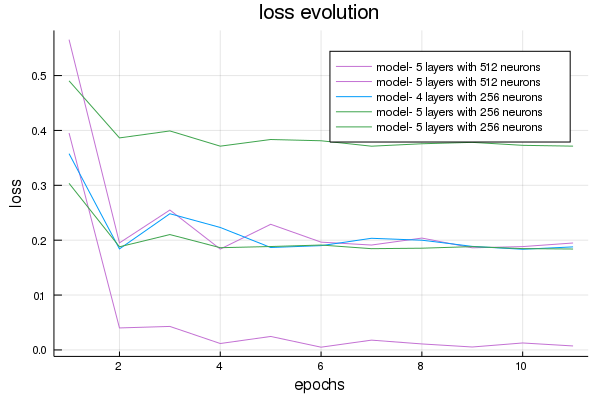

In [93]:
gr(fmt=:png)
plot()
for i = 1:length(model_all_losses)
    this_model_losses = model_all_losses[i]
    this_model = models_tested[i]
    num_layers = length(this_model.layers)
    num_neurons = size(this_model.layers[1].W, 1)
#     p = plotLossOnSameFigure!(this_model_losses, "model- $num_layers layers with $num_neurons neurons")
    colorNum = findColorNum(num_layers, num_neurons)
    p = plotLossOnSameFigure!(this_model_losses, "model- $num_layers layers with $num_neurons neurons", colorNum)
end
display(p)

# Example of how to use Flux

In [25]:
function train_model(model, X_train, Y_train; verbose = false)
    loss(x, y) = Flux.mse(model(x), y)
    data = repeated((X_train, Y_train), 10)
    opt = Flux.Optimise.ADAM()
    lossVals = [loss(X_train,Y_train)]
    evalcb = () -> begin curLoss = loss(X_train,Y_train)
        push!(lossVals, curLoss)
        verbose && @show(curLoss) end
    evalcb2 = () -> BSON.@save "model-flux-trial.bson" model
    verbose && @show loss(X_train,Y_train)
    @epochs 10 Flux.train!(loss, params(model), data, opt, cb = [throttle(evalcb, 30), throttle(evalcb2, 60)])
    verbose && @show lossVals
    verbose && plotLoss(lossVals)
    return lossVals
end

train_model (generic function with 1 method)

In [26]:
input_size = 3
output_size = 1
X_train = [zeros(input_size,10) ones(input_size,10) 2*ones(input_size,10) 3*ones(input_size,10) zeros(input_size,10)]
Y_train = [zeros(output_size,10) ones(output_size,10) ones(output_size,10) ones(output_size,10) zeros(output_size,10)]
model = Chain(Dense(input_size,128, relu), Dense(128,output_size, relu)) 


Chain(Dense(3, 128, NNlib.relu), Dense(128, 1, NNlib.relu))

In [24]:
train_model(model, X_train, Y_train)

┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


11-element Array{Tracker.TrackedReal{Float64},1}:
 0.1010516373091754 
 0.08940615105724167
 0.08370742327295927
 0.08293620163619472
 0.08452701673931094
 0.08556390417860624
 0.08490720399302261
 0.0829203202384882 
 0.08042257133895689
 0.07805512617701264
 0.07630893619236821

In [27]:
train_model(model, X_train, Y_train, verbose = true)

loss(X_train, Y_train) = 0.6 (tracked)
curLoss = 0.6 (tracked)


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


curLoss = 0.6 (tracked)
curLoss = 0.6 (tracked)
curLoss = 0.6 (tracked)
curLoss = 0.6 (tracked)
curLoss = 0.6 (tracked)
curLoss = 0.6 (tracked)
curLoss = 0.6 (tracked)


┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


curLoss = 0.6 (tracked)
curLoss = 0.6 (tracked)


┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


lossVals = Tracker.TrackedReal{Float64}[0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]


11-element Array{Tracker.TrackedReal{Float64},1}:
 0.6
 0.6
 0.6
 0.6
 0.6
 0.6
 0.6
 0.6
 0.6
 0.6
 0.6

In [91]:
@show model(ones(input_size,1))
@show model(3*ones(input_size,1))
@show model(5*ones(input_size,1))
@show model(zeros(input_size,1))

model(ones(input_size, 1)) = Float32[1.00201] (tracked)
model(3 * ones(input_size, 1)) = Float32[0.996905] (tracked)
model(5 * ones(input_size, 1)) = Float32[0.986082] (tracked)
model(zeros(input_size, 1)) = Float32[0.0] (tracked)


Tracked 1×1 Array{Float32,2}:
 0.0f0

# Example of ExprOptimization

In [177]:
const grammar = @grammar begin
    Real = x
    Real = Real * Real
    Real = Real + Real
    Real = Real - Real
    Real = |(1:5)
end

1: Real = x
2: Real = Real * Real
3: Real = Real + Real
4: Real = Real - Real
5: Real = 1
6: Real = 2
7: Real = 3
8: Real = 4
9: Real = 5


In [178]:
const S = SymbolTable(grammar)


Dict{Symbol,Any} with 5 entries:
  :+    => +
  :Real => Real
  :-    => -
  :*    => *
  :x    => [1, 2, 3, 2]

In [179]:
ground_truth(x) = x*x + 2x + 1
function loss(tree::RuleNode, grammar::Grammar)
    ex = get_executable(tree, grammar)
    los = 0.0
    for x = -5.0:1.0:5.0
        S[:x] = x
        los += abs2(Core.eval(S,ex) - ground_truth(x))
    end
    los
end

loss (generic function with 2 methods)

## MonteCarlo Arguments:
- num_samples::Int: number of samples
- max_depth::Int: maximum depth of derivation tree

In [180]:
using Random
Random.seed!(10)
p = MonteCarlo(20000, 6)
results_mc = optimize(p, grammar, :Real, loss)
(results_mc.expr, results_mc.loss)

(:((x + 3) * x), 121.0)

In [182]:
display(results_mc.tree, grammar)


TreeView.LabelledTree({5, 4} directed simple Int64 graph, Any[:*, :+, :x, 3, :x])

## GeneticProgram Arguments
- pop_size::Int: population size
- iterations::Int: number of iterations
- max_depth::Int: maximum depth of derivation tree
- p_reproduction::Float64: probability of reproduction operator
- p_crossover::Float64: probability of crossover operator
- p_mutation::Float64: probability of mutation operator
- init_method::InitializationMethod: initialization method
- select_method::SelectionMethod: selection method

In [184]:
Random.seed!(1)
p = GeneticProgram(1000,20,6,0.3,0.3,0.4)
results_gp = optimize(p, grammar, :Real, loss)
(results_gp.expr, results_gp.loss)

(:((x * 2 + (x * x - 3)) + 4), 0.0)

In [186]:
@show results_gp

results_gp = ExprOptResult(3{3{2{1,6}4{2{1,1}7}}8}, 0.0, :((x * 2 + (x * x - 3)) + 4), nothing)


ExprOptResult(3{3{2{1,6}4{2{1,1}7}}8}, 0.0, :((x * 2 + (x * x - 3)) + 4), nothing)

# True grammar

In [4]:
input_size = 1
output_size = 1
X_train = [zeros(input_size,10) ones(input_size,10) 2*ones(input_size,10) 3*ones(input_size,10) zeros(input_size,10)]
Y_train = [zeros(output_size,10) ones(output_size,10) ones(output_size,10) ones(output_size,10) zeros(output_size,10)]

X_test = [zeros(input_size,2) 2*ones(input_size,2) 3*ones(input_size,2)]
Y_test = [zeros(input_size,2) ones(input_size,2) ones(input_size,2)]


1×6 Array{Float64,2}:
 0.0  0.0  1.0  1.0  1.0  1.0

In [5]:
const grammar = @grammar begin
model = Chain(in_layer, layer, layer, out_layer) | Chain(in_layer, layer, layer, layer, out_layer)
in_layer = Dense(input_size, 256, activation)
out_layer = Dense(256, output_size, activation)
layer = Dense(256,256, activation)
activation = relu
end

1: model = Chain(in_layer, layer, layer, out_layer)
2: model = Chain(in_layer, layer, layer, layer, out_layer)
3: in_layer = Dense(input_size, 256, activation)
4: out_layer = Dense(256, output_size, activation)
5: layer = Dense(256, 256, activation)
6: activation = relu


In [6]:
const S = SymbolTable(grammar)


Dict{Symbol,Any} with 5 entries:
  :output_size => 1
  :relu        => relu
  :Chain       => Chain
  :Dense       => Dense
  :input_size  => 1

In [7]:
# dmap = mindepth_map(grammar)
# best_tree, best_loss = RuleNode(0), Inf

# typ = :model

# tree = rand(RuleNode, grammar, typ, dmap, p.max_depth)
# ex = get_executable(tree, grammar)
# model = Core.eval(S,ex)


UndefVarError: UndefVarError: p not defined

In [17]:
function loss(tree::RuleNode, grammar::Grammar)
    ex = get_executable(tree, grammar)
    model = []
    model = Core.eval(S,ex)
    println(model)
    push!(models_tested, model)
    train_model(model, X_train, Y_train, verbose = false)

    Y_NN = model(X_test)
    println("input $X_test")
    Y_NN = [Tracker.data(ynn) for ynn in Y_NN]
    println("output $Y_NN")
    println("expected output $Y_test")
    los = norm(Y_NN - Y_test)
    push!(model_losses, los)
    println("returning $los")
    return los
end

loss (generic function with 1 method)

In [18]:
using Random
Random.seed!(10)
p = MonteCarlo(2, 2)

models_tested = []
model_losses = []

results_mc = optimize(p, grammar, :model, loss, verbose = true)


samples: 1 of 2
Chain(Dense(1, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 1, NNlib.relu))


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


input [0.0 0.0 2.0 2.0 3.0 3.0]
output Float32[0.0 0.0 1.01624 1.01624 0.992336 0.992336]
expected output [0.0 0.0 1.0 1.0 1.0 1.0]
returning 0.025393422498184843
samples: 2 of 2
Chain(Dense(1, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 256, NNlib.relu), Dense(256, 1, NNlib.relu))


┌ Info: Epoch 1
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 9
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105
┌ Info: Epoch 10
└ @ Main /home/somrita/.julia/packages/Flux/qXNjB/src/optimise/train.jl:105


input [0.0 0.0 2.0 2.0 3.0 3.0]
output Float32[0.0 0.0 0.0 0.0 0.0 0.0]
expected output [0.0 0.0 1.0 1.0 1.0 1.0]
returning 2.0


ExprOptResult(2{3{6}5{6}5{6}5{6}4{6}}, 0.025393422498184843, :(Chain(Dense(input_size, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, output_size, relu))), nothing)

In [19]:
(results_mc.expr, results_mc.loss)

(:(Chain(Dense(input_size, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, output_size, relu))), 0.025393422498184843)

In [20]:
@show models_tested
@show model_losses

models_tested = Any[Chain(Dense(1, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 1, relu)), Chain(Dense(1, 256, relu), Dense(256, 256, relu), Dense(256, 256, relu), Dense(256, 1, relu))]
model_losses = Any[0.0253934, 2.0]


2-element Array{Any,1}:
 0.025393422498184843
 2.0                 

In [21]:
size(X_test)

(1, 6)

In [34]:
ark = 3
println("returning $ark")

returning 3


# Scrap

In [ ]:
# dmap = mindepth_map(grammar)
# best_tree, best_loss = RuleNode(0), Inf

# typ = :model

# tree = rand(RuleNode, grammar, typ, dmap, p.max_depth)
# ex = get_executable(tree, grammar)
#     los = 0.0
# x = 1.0
# S[:x] = x
# model = Core.eval(S,ex)

# X_train = [zeros(input_size,10) ones(input_size,10) 2*ones(input_size,10) 3*ones(input_size,10) zeros(input_size,10)]
# Y_train = [zeros(output_size,10) ones(output_size,10) ones(output_size,10) ones(output_size,10) zeros(output_size,10)]

# train_model(model, X_train, Y_train, verbose = false)

# los = loss(tree, grammar)

In [30]:
@grammar begin
model = Chain(layer, layer, layer, layer, relu) | Chain(layer, layer, layer, layer, layer, relu)
layer = Dense(n, activation)
n = 128|256|512|1024
activation = relu
end

1: model = Chain(layer, layer, layer, layer, relu)
2: model = Chain(layer, layer, layer, layer, layer, relu)
3: layer = Dense(n, activation)
4: n = 128
5: n = 256
6: n = 512
7: n = 1024
8: activation = relu


In [1]:
@grammar begin
model = Chain(layer, layer, relu) | Chain(layer, layer, layer, relu)
layer = Dense(n, activation) | OtherLayerType(...)
n = |(50:50:500)
activation = relu | tanh
end

LoadError: syntax: invalid identifier name "..."

In [ ]:
model2 = Chain(
  Dense(10, 5, σ),
  Dense(5, 2),
  softmax)

In [19]:
imgs = MNIST.images()
# Stack images into one large batch
X = hcat(float.(reshape.(imgs, :))...) |> gpu

UndefVarError: UndefVarError: MNIST not defined

In [ ]:
function loss(tree::RuleNode, grammar::Grammar)
    ex = get_executable(tree, grammar)
    model = []
    model = Core.eval(S,ex)
    push!(models_tested, model)
    loss_vals = train_model(model, X_train[1,:], Y_train[1,:], verbose = false)

    Y_NN = model(X_test[1,:])
    Y_NN = [Tracker.data(ynn) for ynn in Y_NN]
    los = norm(Y_NN - Y_test[1,:])
    push!(model_final_losses, los)
    push!(model_all_losses, loss_vals)
    final_loss = Tracker.data(loss_vals[end])
    @show final_loss
    println("returning $final_loss")
    return loss_vals[end]
end

In [ ]:
# Classify MNIST digits with a simple multi-layer-perceptron

imgs = MNIST.images()
# Stack images into one large batch
X = hcat(float.(reshape.(imgs, :))...) |> gpu

labels = MNIST.labels()
# One-hot-encode the labels
Y = onehotbatch(labels, 0:9) |> gpu

m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax) |> gpu

loss(x, y) = crossentropy(m(x), y)

accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

dataset = repeated((X, Y), 200)
evalcb = () -> @show(loss(X, Y))
opt = ADAM()

Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 10))

accuracy(X, Y)

# Test set accuracy
tX = hcat(float.(reshape.(MNIST.images(:test), :))...) |> gpu
tY = onehotbatch(MNIST.labels(:test), 0:9) |> gpu

accuracy(tX, tY)
